# Feature comparison between IDEAS, CP and SCIP features

In this notebook, we will compare feature sets generated using IDEAS, CellProfiler and SCIP. 

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [5]:
import seaborn
import fcsparser
from sklearn.preprocessing import scale
from scipy.stats import pearsonr, spearmanr
from ehv import core

In [6]:
from ehv import masking

## Loading the three feature sets

In [5]:
data_root = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc"

In [16]:
data_root = Path("/home/maximl/scratch/data/vsc/datasets/wbc/")

In [17]:
data_scip = data_root / "scip/202204271347/"
data_ideas = data_root / "ideas/202111121025/"

In [15]:
df_scip = pq.read_table(data_scip / "features.parquet").to_pandas()

cat_type = CategoricalDtype(
    categories=sorted(df_scip["meta_group"].astype(int).unique()), ordered=True)
df_scip["meta_group"] = df_scip["meta_group"].astype(int).astype(cat_type)

cat_type = CategoricalDtype(
    categories=sorted(df_scip["meta_part"].astype(int).unique()), ordered=True)
df_scip["meta_part"] = df_scip["meta_part"].astype(int).astype(cat_type)

df_scip = df_scip.set_index(["meta_group", "meta_part", "meta_fix", "meta_object_number"])

df_scip = df_scip[numpy.load(
    data_scip / "indices/columns.npy", allow_pickle=True)]
df_scip = df_scip.loc[numpy.load(
    data_scip / "indices/index.npy", allow_pickle=True)]

df_scip["meta_label"] = pandas.Categorical(df_scip["meta_label"], ordered=True)

df_scip.shape

(233262, 2200)

In [20]:
# ideas features
def proc_cols(cols):
    out = []
    for col in cols:
        col = col.lower()
        for c in [" ", "-", "_", "."]:
            col = col.replace(c, "")
        out.append(col)
    return out

tmp = []
cols = None
for p in data_ideas.glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("wbc(?P<group>[0-9])_(?P<part>[0-9])_?(?P<fix>(early|late))?.fcs", p.name).groupdict()
    data["fix"] = groups["fix"]
    data["group"] = int(groups["group"])
    data["part"] = int(groups["part"])
    data.columns = proc_cols(data.columns)
    if cols is None:
        cols = data.columns  
    tmp.append(data[cols])
df_ideas = pandas.concat(tmp, axis=0)

r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)

ideas_meta_cols = ["objectnumber", "fix", "group", "part"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_objectnumber"].astype(int)
df_ideas = df_ideas.drop(columns="meta_objectnumber")

df_ideas = df_ideas.set_index(["meta_object_number", "meta_part", "meta_group", "meta_fix"])

df_ideas.shape

(274050, 305)

# Comparing features between IDEAS and SCIP

In [21]:
df_joined = df_scip.rename(columns=lambda a: "scip_"+a).join(
    df_ideas.rename(columns=lambda a: "ideas_"+a), 
    on=["meta_object_number", "meta_part", "meta_group", "meta_fix"], 
    how="left", lsuffix="ideas", rsuffix="scip"
)
df_joined.shape

(233262, 2505)

In [22]:
def rename(c):
    if c.startswith("scip_meta"):
        return "meta_" + c[10:]
    return c
df_joined = df_joined.rename(columns=rename)

In [23]:
def compare_features(df, x1, x2):
    fig, ax = plt.subplots(dpi=150)
    ax.set_xlabel(x1)
    ax.set_ylabel(x2)
    sorted_index = df[x1].sort_values().index
    z1 = df[x1].values
    z2 = df[x2].values

    sorted_index = numpy.argsort(z1)
    z = numpy.polyfit(z1, z2, 1)
    y_hat = numpy.poly1d(z)(z1[sorted_index])
    ax.plot(z1[sorted_index], y_hat, "--", lw=0.5, color="grey")
    ax.scatter(z1[sorted_index], z2[sorted_index], s=0.5, alpha=0.5, edgecolors="none")
    # ax.set_title(r'pearson = %.4f, spearman = %.4f' % (pearsonr(z1,z2)[0], spearmanr(z1,z2)[0]))
    
    return ax

### Texture

<AxesSubplot:xlabel='ideas_feat_hcontrastmeanm06ssc5', ylabel='scip_feat_glcm_mean_homogeneity_5_SSC'>

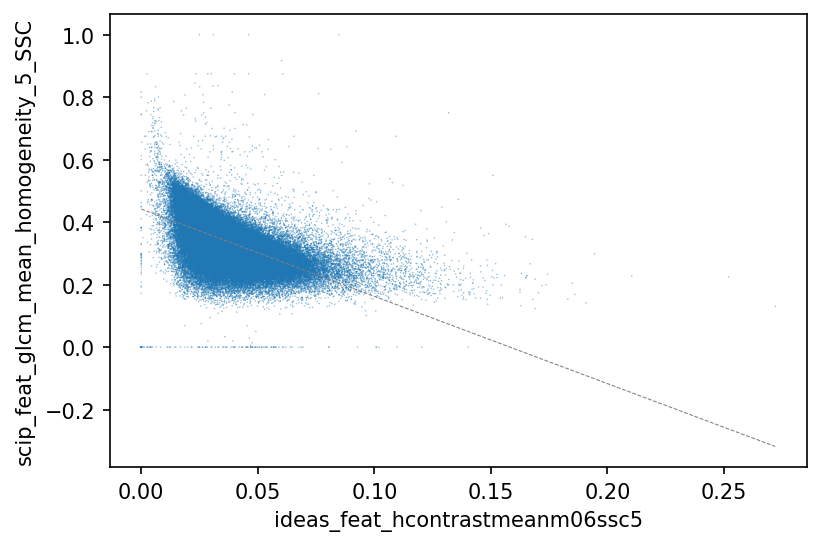

In [24]:
compare_features(df_joined, "ideas_feat_hcontrastmeanm06ssc5", "scip_feat_glcm_mean_homogeneity_5_SSC")

In [17]:
sel1 = ~df_joined["ideas_feat_hcontrastmeanm06ssc5"].isna()
sel2 = df_joined["scip_feat_glcm_mean_homogeneity_5_SSC"].isna()
r = df_joined[sel1 & sel2].iloc[10]

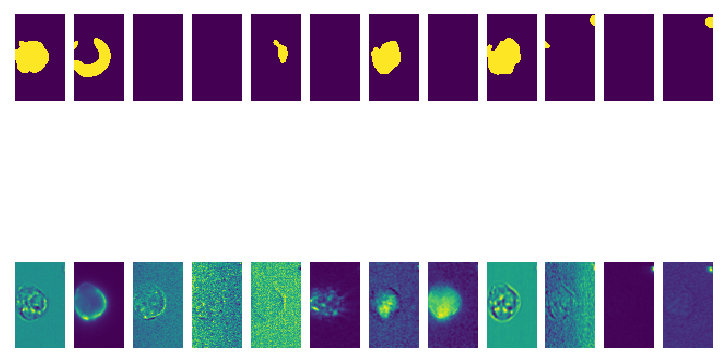

In [18]:
_ = masking.plot_scip_segmentation(r, smooth=1)

### Shape

<AxesSubplot:xlabel='ideas_feat_circularitym01', ylabel='scip_feat_eccentricity_BF1'>

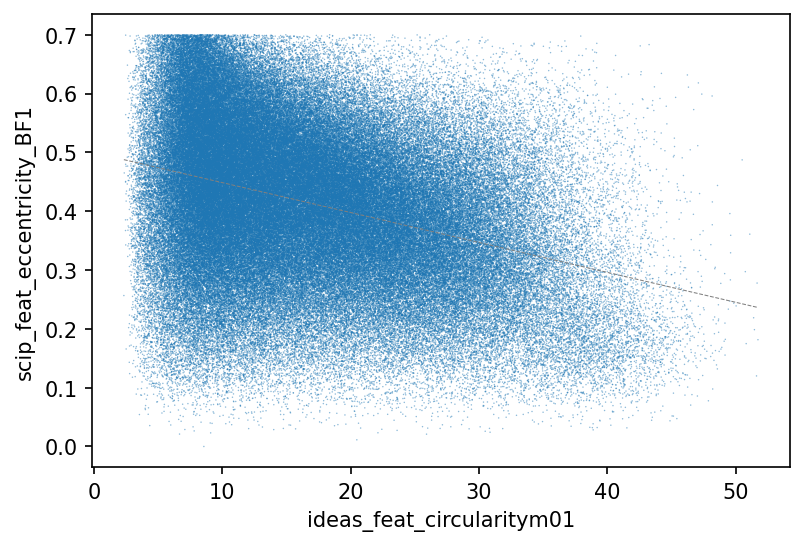

In [25]:
compare_features(df_joined, "ideas_feat_circularitym01", "scip_feat_eccentricity_BF1")

<AxesSubplot:xlabel='ideas_feat_majoraxism01', ylabel='scip_feat_major_axis_length_BF1'>

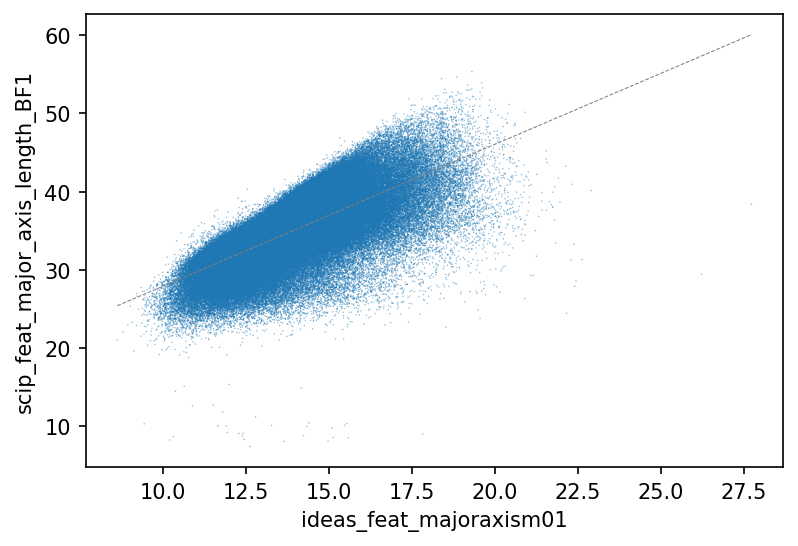

In [26]:
compare_features(df_joined, "ideas_feat_majoraxism01", "scip_feat_major_axis_length_BF1")

<AxesSubplot:xlabel='ideas_feat_aream01', ylabel='scip_feat_area_BF1'>

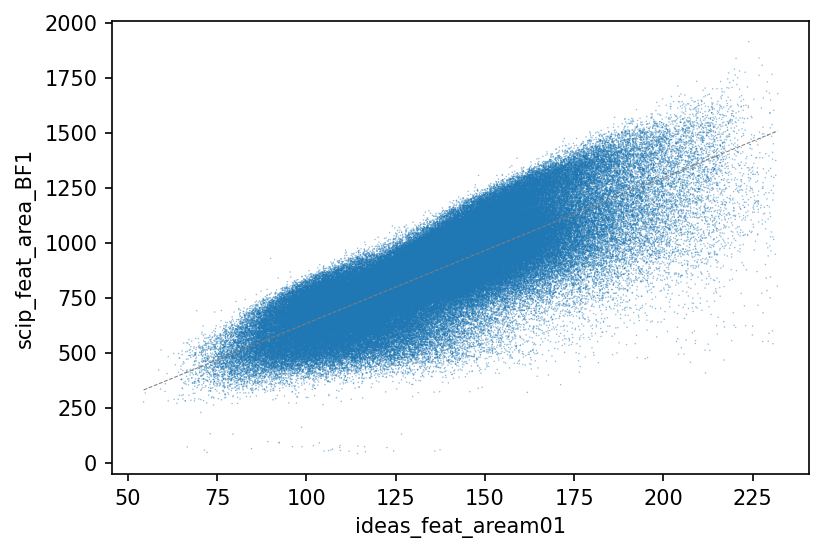

In [27]:
compare_features(df_joined, "ideas_feat_aream01", "scip_feat_area_BF1")

<AxesSubplot:xlabel='ideas_feat_aream02', ylabel='scip_feat_area_CD15'>

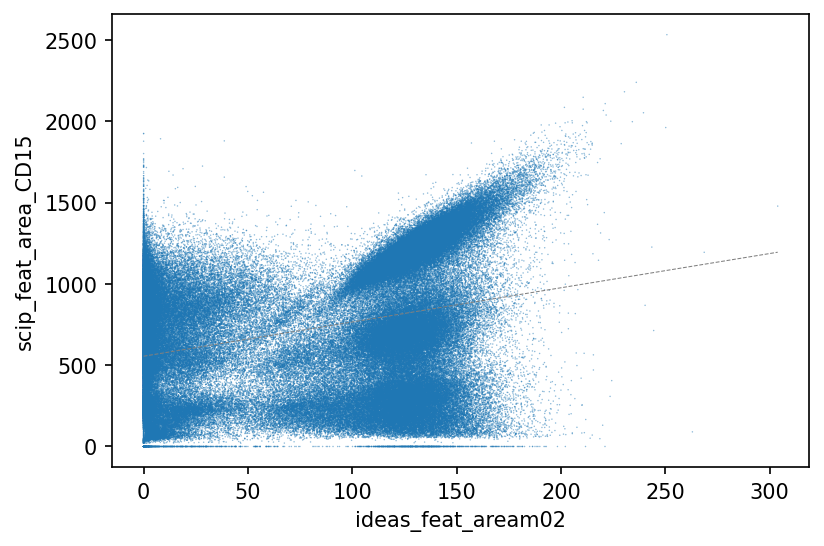

In [28]:
compare_features(df_joined, "ideas_feat_aream02", "scip_feat_area_CD15")

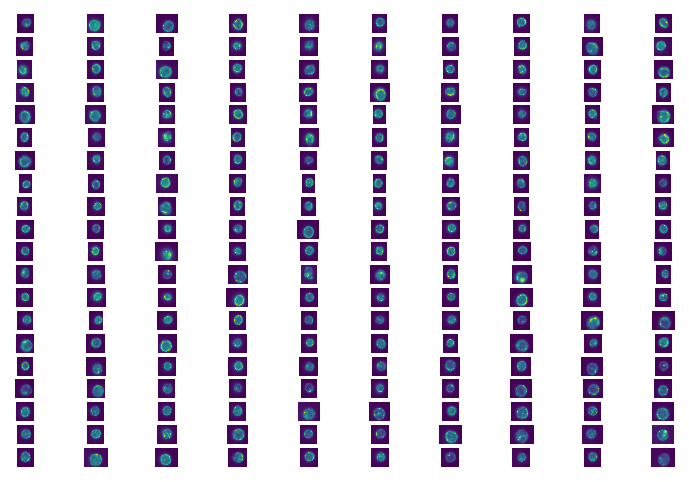

In [23]:
sel1 = df_joined["scip_feat_area_CD15"] > 1100
sel2 = df_joined["scip_feat_area_CD15"] < 1250
sel3 = df_joined["ideas_feat_aream02"] > 100
sel4 = df_joined["ideas_feat_aream02"] < 150
core.plot_gate_zarr(sel1 & sel2 & sel3 & sel4, df_joined, channel=1)

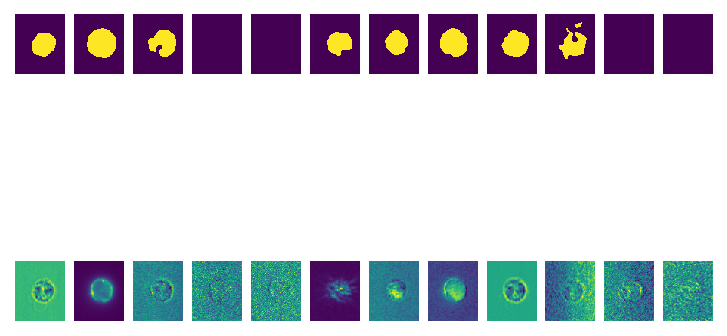

In [24]:
r = df_joined[sel1 & sel2 & sel3 & sel4].iloc[10]
_ = masking.plot_scip_segmentation(r)

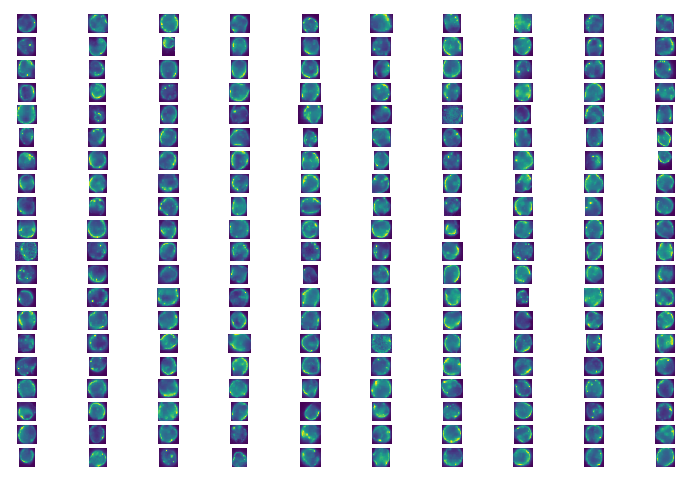

In [379]:
sel1 = df_joined["scip_feat_area_CD15"] > 500
sel2 = df_joined["scip_feat_area_CD15"] < 750
sel3 = df_joined["ideas_feat_aream02"] > 100
sel4 = df_joined["ideas_feat_aream02"] < 150
core.plot_gate_zarr(sel1 & sel2 & sel3 & sel4, df_joined, channel=1)

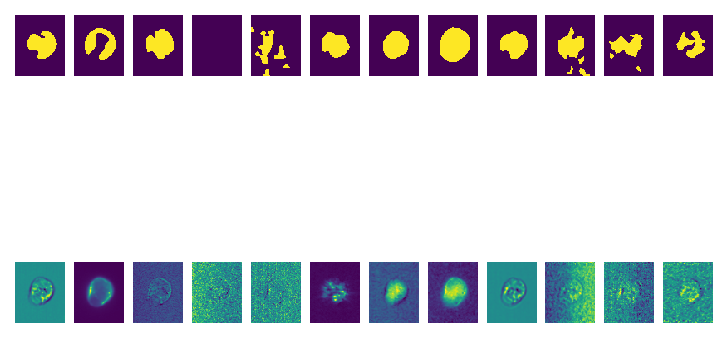

In [380]:
r = df_joined[sel1 & sel2 & sel3 & sel4].iloc[10]
_ = masking.plot_scip_segmentation(r)

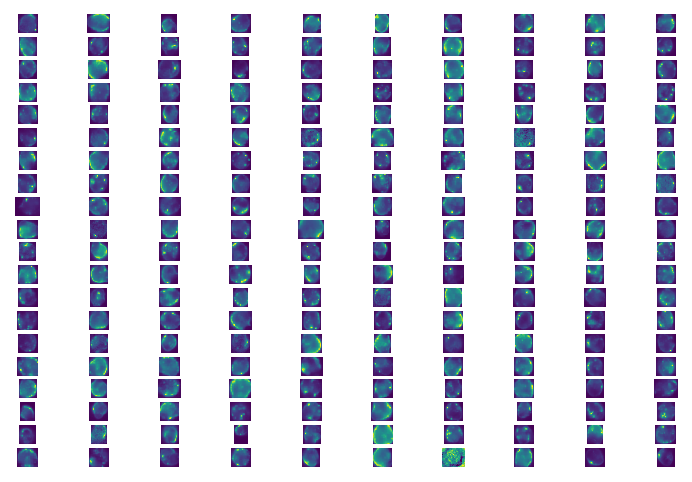

In [381]:
sel1 = df_joined["scip_feat_area_CD15"] > 50
sel2 = df_joined["scip_feat_area_CD15"] < 250
sel3 = df_joined["ideas_feat_aream02"] > 100
sel4 = df_joined["ideas_feat_aream02"] < 150
core.plot_gate_zarr(sel1 & sel2 & sel3 & sel4, df_joined, channel=1)

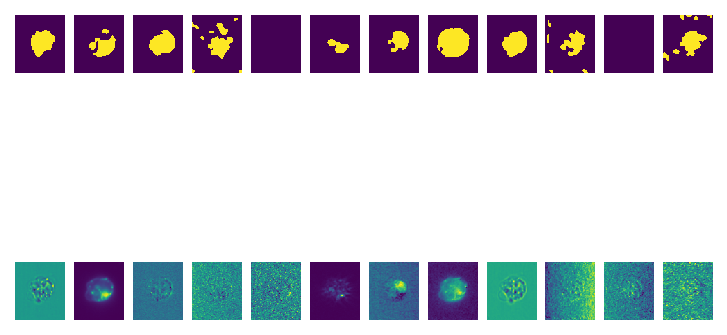

In [382]:
r = df_joined[sel1 & sel2 & sel3 & sel4].iloc[10]
_ = masking.plot_scip_segmentation(r)

<AxesSubplot:xlabel='ideas_feat_aream03', ylabel='scip_feat_area_Siglec8'>

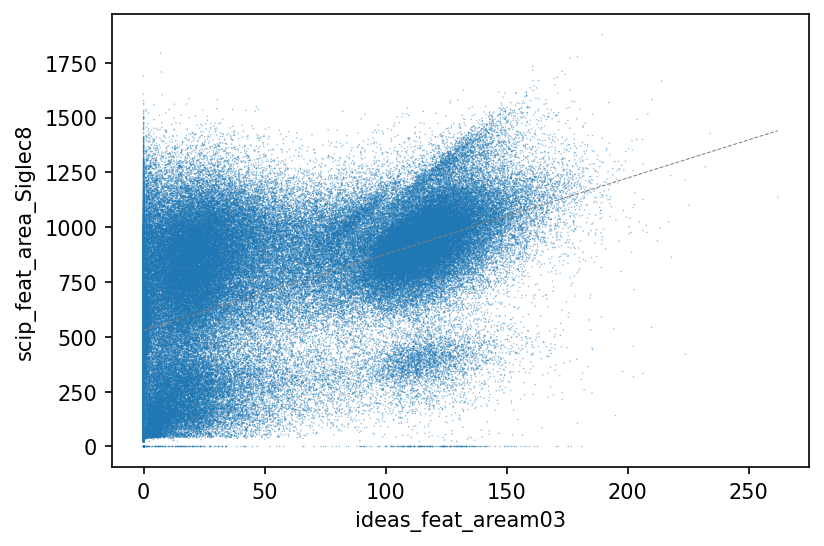

In [29]:
compare_features(df_joined, "ideas_feat_aream03", "scip_feat_area_Siglec8")

<AxesSubplot:xlabel='ideas_feat_perimeterm01', ylabel='scip_feat_perimeter_BF1'>

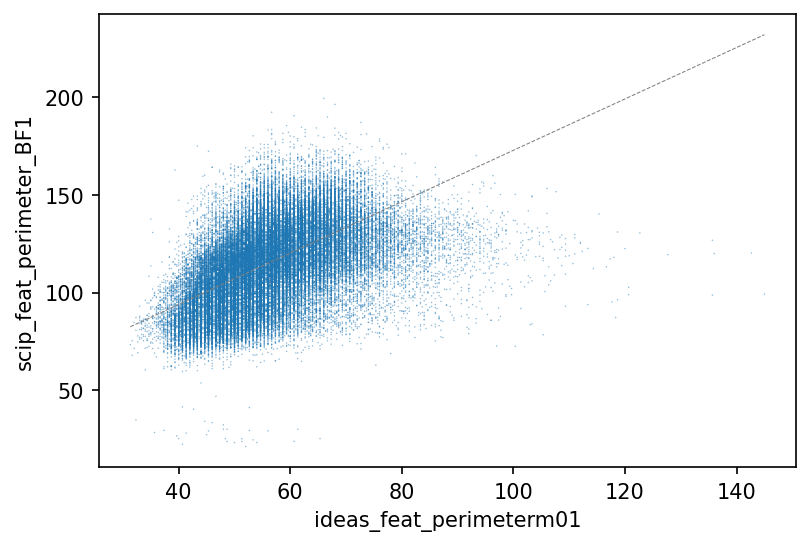

In [30]:
compare_features(df_joined, "ideas_feat_perimeterm01", "scip_feat_perimeter_BF1")

<AxesSubplot:xlabel='ideas_feat_majoraxism06', ylabel='scip_feat_major_axis_length_SSC'>

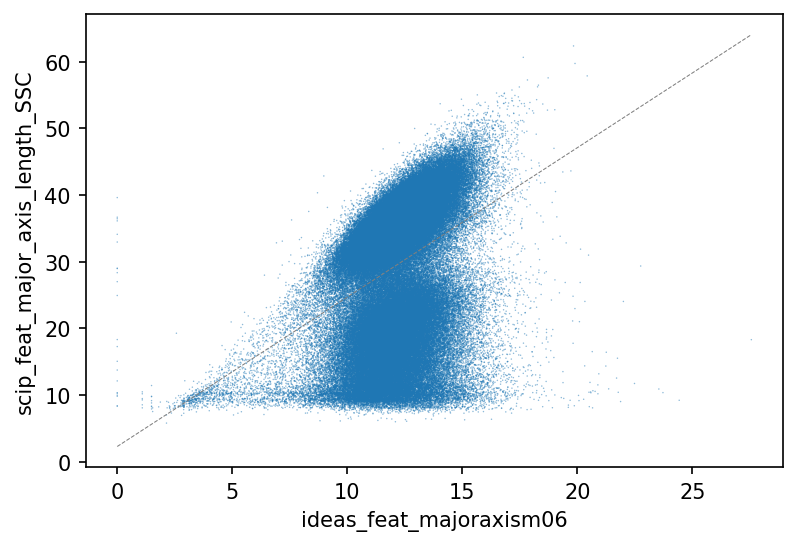

In [31]:
compare_features(df_joined, "ideas_feat_majoraxism06", "scip_feat_major_axis_length_SSC")

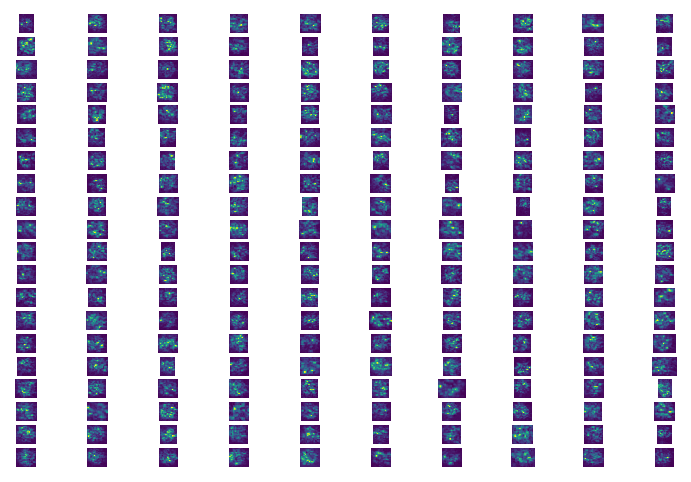

In [352]:
sel1 = df_joined["scip_feat_major_axis_length_SSC"] < 40
sel2 = df_joined["scip_feat_major_axis_length_SSC"] > 30
sel3 = df_joined["ideas_feat_majoraxism06"] > 10
sel4 = df_joined["ideas_feat_majoraxism06"] < 15
core.plot_gate_zarr(sel1 & sel2 & sel3 & sel4, df_joined, channel=5)

In [357]:
r = df_joined[sel1 & sel2 & sel3 & sel4].iloc[10]

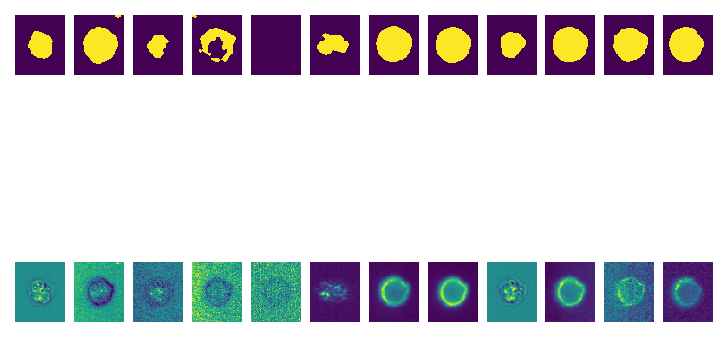

In [358]:
_ = masking.plot_scip_segmentation(r)

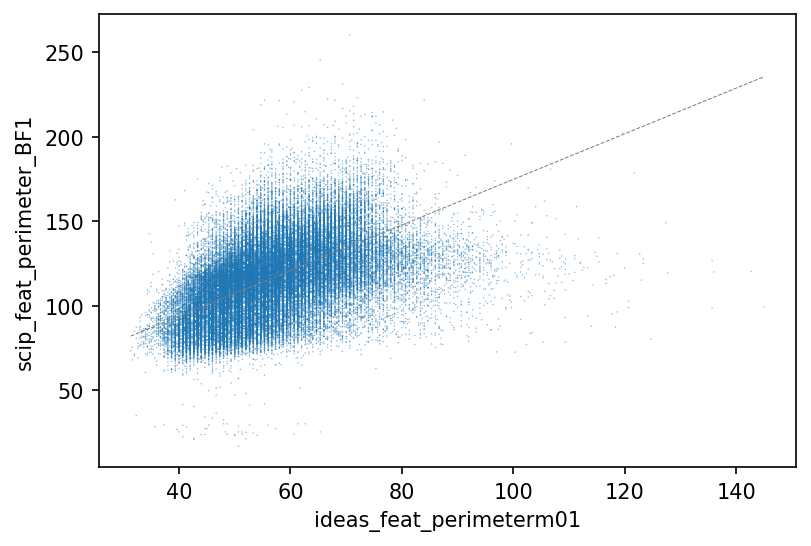

In [28]:
compare_features(df_joined, "ideas_feat_perimeterm01", "scip_feat_perimeter_BF1")

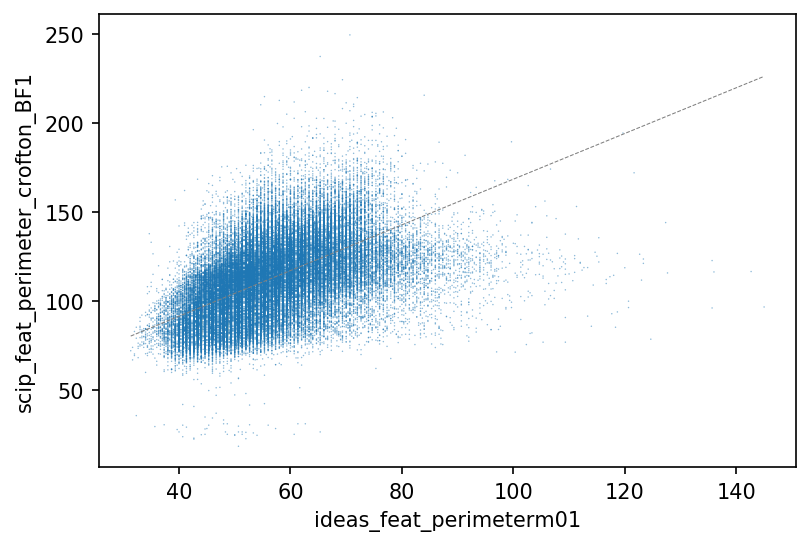

In [29]:
compare_features(df_joined, "ideas_feat_perimeterm01", "scip_feat_perimeter_crofton_BF1")

<AxesSubplot:xlabel='ideas_feat_aream07', ylabel='scip_feat_area_CD3'>

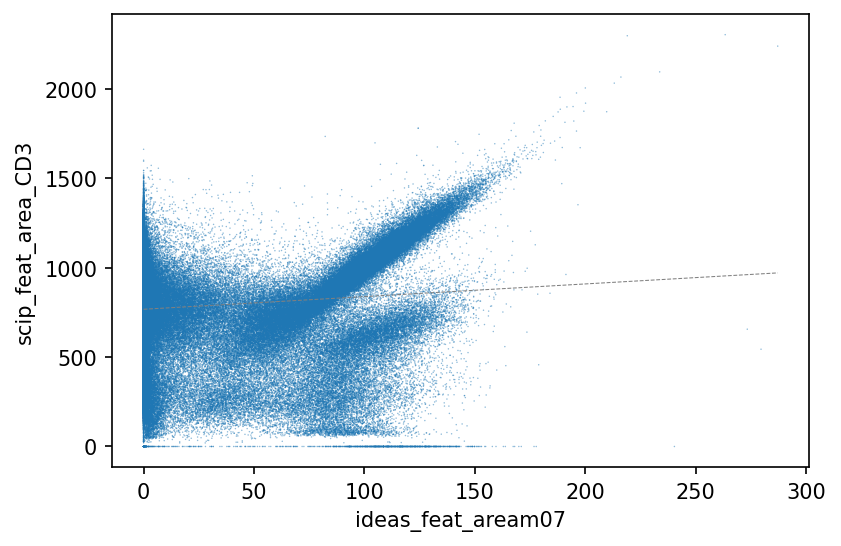

In [32]:
compare_features(df_joined, "ideas_feat_aream07", "scip_feat_area_CD3")

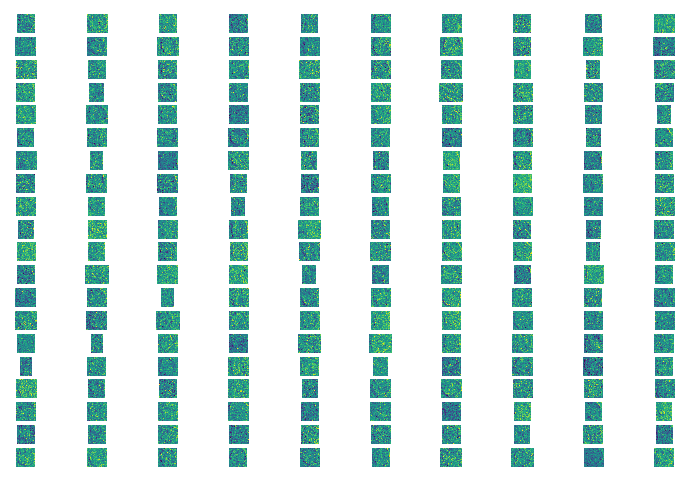

In [360]:
sel1 = df_joined["scip_feat_area_CD3"] > 0
sel2 = df_joined["ideas_feat_aream07"] == 0
core.plot_gate_zarr(sel1 & sel2, df_joined, channel=4)

In [361]:
r = df_joined[sel1 & sel2].iloc[5]

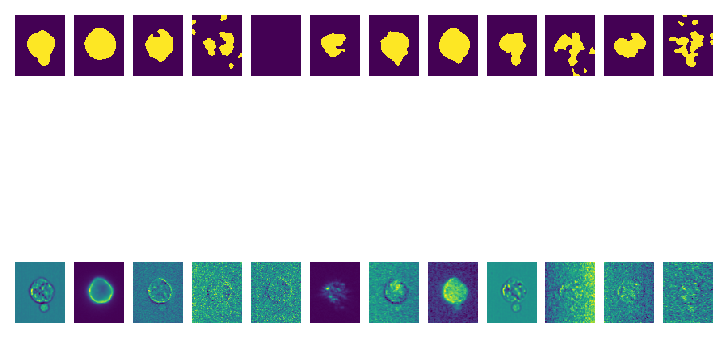

In [362]:
_ = masking.plot_scip_segmentation(r)

### Intensity features

<AxesSubplot:xlabel='ideas_feat_rawintensitym06ssc', ylabel='scip_feat_sum_SSC'>

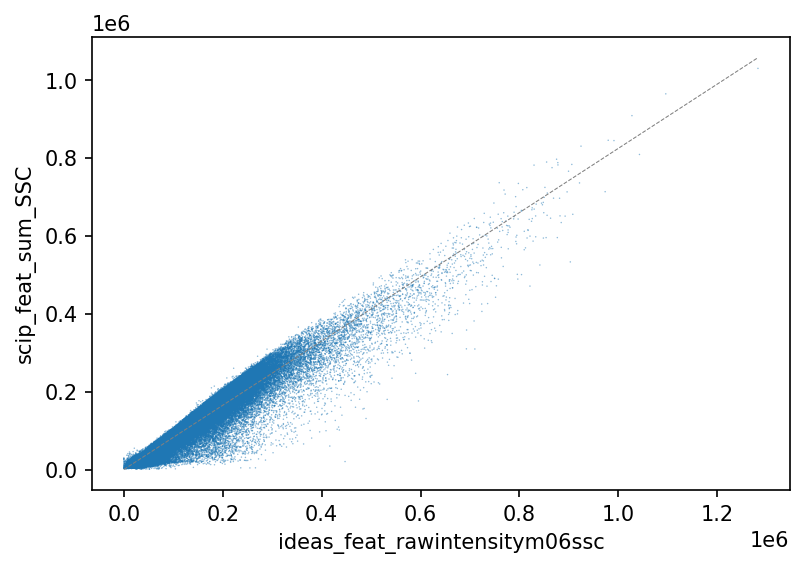

In [33]:
compare_features(df_joined, "ideas_feat_rawintensitym06ssc", "scip_feat_sum_SSC")

<AxesSubplot:xlabel='ideas_feat_intensitym01bf420nm480nm', ylabel='scip_feat_bgcorr_sum_BF1'>

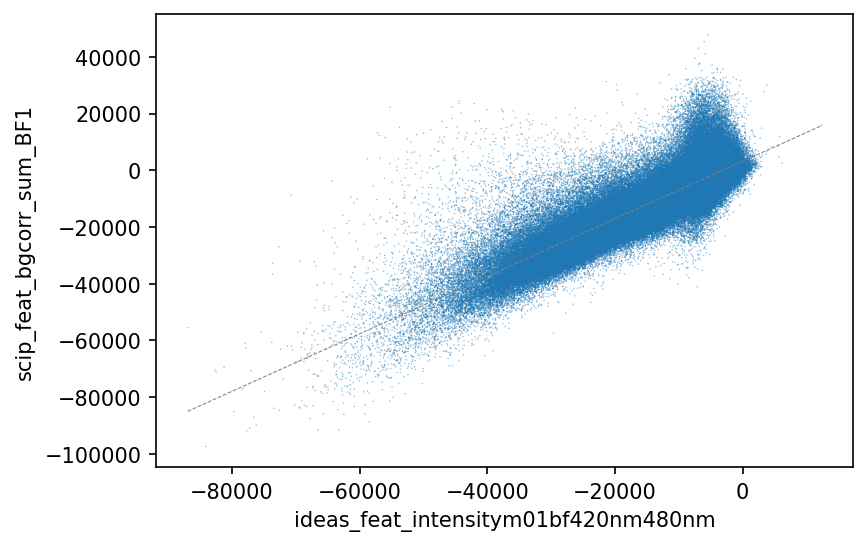

In [34]:
compare_features(df_joined, "ideas_feat_intensitym01bf420nm480nm", "scip_feat_bgcorr_sum_BF1")

<AxesSubplot:xlabel='ideas_feat_rawintensitym01bf420nm480nm', ylabel='scip_feat_sum_BF1'>

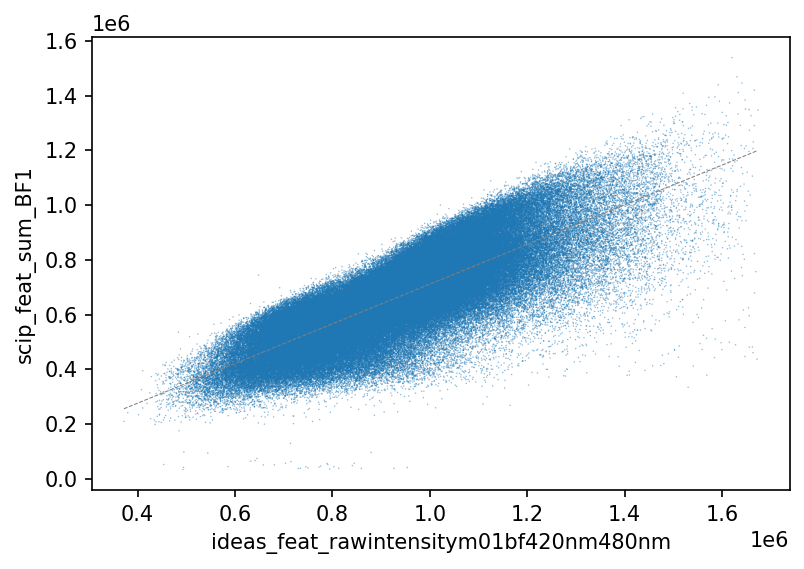

In [35]:
compare_features(df_joined, "ideas_feat_rawintensitym01bf420nm480nm", "scip_feat_sum_BF1")

<AxesSubplot:xlabel='ideas_feat_intensitymccd15fitc', ylabel='scip_feat_combined_bgcorr_sum_CD15'>

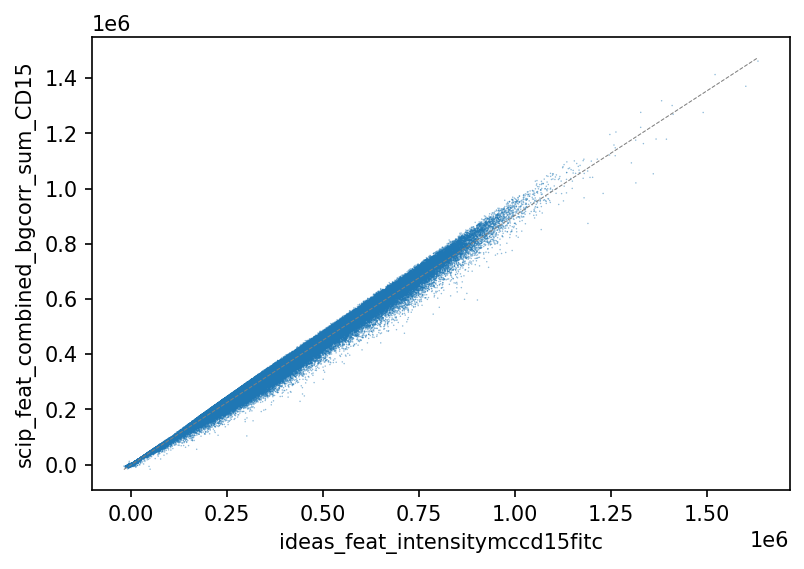

In [36]:
compare_features(df_joined, "ideas_feat_intensitymccd15fitc", "scip_feat_combined_bgcorr_sum_CD15")

<AxesSubplot:xlabel='ideas_feat_intensitymccd3bv421', ylabel='scip_feat_combined_bgcorr_sum_CD3'>

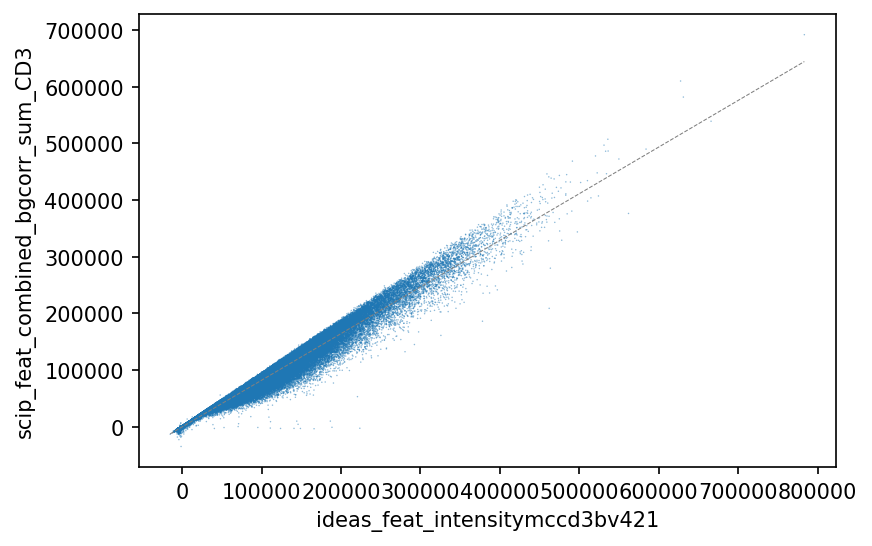

In [37]:
compare_features(df_joined, "ideas_feat_intensitymccd3bv421", "scip_feat_combined_bgcorr_sum_CD3")